In [42]:
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.impute import SimpleImputer

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
import lightgbm as lgb

from main import import_dataset_from_file, export_dataset_to_file

In [43]:
data_path = '../Data/'

# Вспомогательные данные, по которым производится моделирование
map_1_dataset = import_dataset_from_file(data_path + "/Map_1.txt")
map_2_dataset = import_dataset_from_file(data_path + "/Map_2.txt")
map_3_dataset = import_dataset_from_file(data_path + "/Map_3.txt")
map_4_dataset = import_dataset_from_file(data_path + "/Map_4.txt")
map_5_dataset = import_dataset_from_file(data_path + "/Map_5.txt")

# Данные, по которым необходимо смоделировать
point_dataset = import_dataset_from_file(data_path + "/Point_dataset.txt")

# Точки данных, в которые необходимо провести моделирование (сетка данных)
point_grid = import_dataset_from_file(data_path + "/Result_schedule.txt")

In [3]:
point_dataset

,x,y,z
0,44222.21,35600.90,14.974396
1,60003.40,26172.72,14.078868
2,44300.61,35291.79,14.261570
3,52776.47,33453.18,15.347562
4,49636.39,30697.34,14.422570
...,...,...,...
436,65193.40,26832.74,9.374795
437,50022.04,40606.42,7.636603
438,43745.18,35114.25,14.622497
439,71483.43,25152.76,11.014532


In [4]:
map_1_dataset

,x,y,z
0,68239.21,24467.0,0.15633
1,68251.71,24467.0,0.15675
2,68264.21,24467.0,0.15718
3,68276.71,24467.0,0.15698
4,68289.21,24467.0,0.15696
...,...,...,...
1196490,53239.21,46942.0,0.16870
1196491,53251.71,46942.0,0.16834
1196492,53264.21,46942.0,0.16873
1196493,53276.71,46942.0,0.16878


In [5]:
point_grid

,x,y,z
0,68239.21,24467.0,NaN
1,68251.71,24467.0,NaN
2,68264.21,24467.0,NaN
3,68276.71,24467.0,NaN
4,68289.21,24467.0,NaN
...,...,...,...
1196585,53264.21,46942.0,NaN
1196586,53276.71,46942.0,NaN
1196587,53289.21,46942.0,NaN
1196588,53301.71,46942.0,NaN


In [6]:
def get_subface(df: pd.DataFrame):
    fig, ax = plt.subplots(sharex=True, sharey=True)

    # Make data.
    X = df['x']
    Y = df['y']
    #X, Y = np.meshgrid(X, Y)
    Z = df['z']

    # Plot the surface.
    ax.scatter(X, Y, c=Z, s=1)


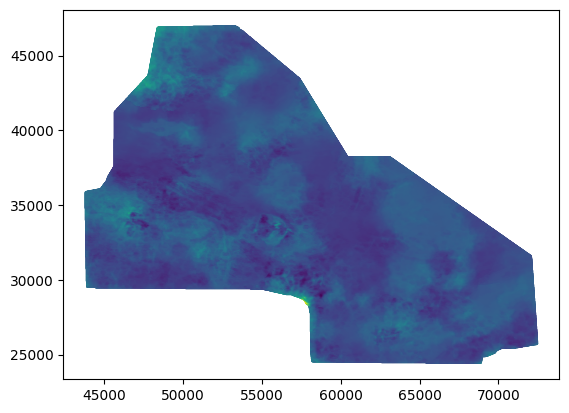

In [7]:
get_subface(map_1_dataset)

# Dataset

In [48]:
df = map_1_dataset.rename(columns={'z': 'map_1'})
# df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

for idx, another_df in enumerate([map_2_dataset, map_3_dataset, map_4_dataset, map_5_dataset]):
    another_df = another_df.rename(columns={'z': 'map_' + str(idx + 2)})
    df = df.merge(another_df, how='outer', on=['x', 'y'])
    print(df.columns)

Index(['x', 'y', 'map_1', 'map_2'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3', 'map_4'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3', 'map_4', 'map_5'], dtype='object')


In [49]:
## доп фичи ##
for i in range(1, 6):
    for j in range(1, 6):
        df[f'mul_map_{i}_{j}'] = df[f'map_{i}'] * df[f'map_{j}']
        if i != j:
            df[f'sub_map_{i}_{j}'] = df[f'map_{i}'] - df[f'map_{j}']
            df[f'add_map_{i}_{j}'] = df[f'map_{i}'] + df[f'map_{j}']

for i in range(1, 6):
    df[f'mean_map_{i}'] = df[f'map_{i}'].mean()
    df[f'min_map_{i}'] = df[f'map_{i}'].min()
    df[f'max_map_{i}'] = df[f'map_{i}'].max()

for i in range(1, 6):
    for rad in [11, 101, 1001]:
        df_rad = df['map_1'].rolling(rad, center=True)
        df[f'mean_map_{i}_in_rad{rad}'] = df_rad.mean()
        df[f'min_map_{i}_in_rad{rad}'] = df_rad.min()
        df[f'max_map_{i}_in_rad{rad}'] = df_rad.max()
#############

df = df.copy()

C:\Users\vladi\AppData\Local\Temp\ipykernel_16112\3123169957.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'mean_map_{i}_in_rad{rad}'] = df_rad.mean()
C:\Users\vladi\AppData\Local\Temp\ipykernel_16112\3123169957.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'min_map_{i}_in_rad{rad}'] = df_rad.min()
C:\Users\vladi\AppData\Local\Temp\ipykernel_16112\3123169957.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [90]:
LABEL_COL = 'f1'

def generate_dataset(df, point_dataset, label_col=LABEL_COL, keep_coords=True, how='left', max_distance=1000, max_degree=2):
    df_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
    point_gdf = gpd.GeoDataFrame(point_dataset, geometry=gpd.points_from_xy(point_dataset['x'], point_dataset['y']))
    
    if keep_coords:
        point_gdf = point_gdf.rename(columns={'x': f'x_{label_col}', 'y': f'y_{label_col}', 'z': label_col})

        feat_num = 0
        for degree in range(2, max_degree + 1):
            for t in combinations_with_replacement([f'x_{label_col}', f'y_{label_col}'], degree):
                point_gdf[f'coord_{feat_num}'] = 1
                for feat in t:
                    point_gdf[f'coord_{feat_num}'] *= point_gdf[feat]
                feat_num += 1
    else:
        point_gdf = point_gdf.drop(columns=['x', 'y']).rename(columns={'z': label_col})
    
    df_ = df_.sjoin_nearest(point_gdf, how=how, max_distance=max_distance, distance_col='distance')

    return df_[df_[f'x_{label_col}'].notna()]\
        .drop(columns=['geometry', 'index_right' if how in ['left', 'inner'] else 'index_left'])

In [47]:
df2 = map_1_dataset.rename(columns={'z': 'map_1'})
# df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

for idx, another_df in enumerate([map_2_dataset, map_3_dataset, map_4_dataset, map_5_dataset]):
    another_df = another_df.rename(columns={'z': 'map_' + str(idx + 2)})
    df2 = df2.merge(another_df, how='outer', on=['x', 'y'])
    print(df.columns)

Index(['x', 'y', 'map_1', 'map_2'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3', 'map_4'], dtype='object')
Index(['x', 'y', 'map_1', 'map_2', 'map_3', 'map_4', 'map_5'], dtype='object')


In [156]:
LABEL_COL = 'f1'

def generate_poly_dataset(df, point_dataset, label_col=LABEL_COL, keep_coords=True, how='left', train=False, degree=2, max_distance=1000):
    df_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
    point_gdf = gpd.GeoDataFrame(point_dataset, geometry=gpd.points_from_xy(point_dataset['x'], point_dataset['y']))
    
    if keep_coords:
        point_gdf = point_gdf.rename(columns={'x': f'x_{label_col}', 'y': f'y_{label_col}', 'z': label_col})
    else:
        point_gdf = point_gdf.drop(columns=['x', 'y']).rename(columns={'z': label_col})
    
    df_ = df_.sjoin_nearest(point_gdf, how=how, max_distance=max_distance, distance_col='distance')
    df_ = df_[df_[f'x_{label_col}'].notna()]\
        .drop(columns=['geometry', 'index_right' if how in ['left', 'inner'] else 'index_left'])

    feature_cols = [col for col in df_.columns if col != label_col]
    X, y = df_[feature_cols], df_[label_col]

    if train:
        imputer.fit(X)
    X = imputer.transform(X)

    if train:
        norm.fit(X)
    X = norm.transform(X)

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X[:, -2:])

    features = np.hstack((X[:, :-2], poly_features))

    return features, y


norm = Normalizer()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
generate_poly_dataset(df2, point_dataset, train=True, degree=2, max_distance=100)

(array([[6.54071115e-01, 2.65537787e-01, 1.73288778e-06, ...,
         7.05064091e-02, 2.80034934e-04, 1.11223313e-06],
        [6.54147000e-01, 2.65513693e-01, 1.72970129e-06, ...,
         7.04936144e-02, 2.44079545e-04, 8.45109516e-07],
        [6.54223712e-01, 2.65489944e-01, 1.72024329e-06, ...,
         7.04810044e-02, 2.08138080e-04, 6.14654415e-07],
        ...,
        [5.25524743e-01, 4.72696763e-01, 1.65136154e-06, ...,
         2.22638327e-01, 4.15259914e-04, 7.74533292e-07],
        [5.25617034e-01, 4.72665222e-01, 1.65135323e-06, ...,
         2.22608617e-01, 4.34399902e-04, 8.47690791e-07],
        [5.25709000e-01, 4.72633405e-01, 1.64981578e-06, ...,
         2.22578649e-01, 4.60625548e-04, 9.53262573e-07]]),
 886        18.350161
 887        18.350161
 888        18.350161
 889        18.350161
 890        18.350161
              ...    
 1187949    16.902573
 1187950    16.902573
 1187951    16.902573
 1187952    16.902573
 1187953    16.902573
 Name: f1, Length: 3742

# Training

In [82]:
param = {
    'objective': 'regression',
    'task': 'train',
    'num_iterations': 300,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'num_threads': 4,
    'metric': 'mae,mape',
    'min_data_in_leaf': 300,
}

def train(train_df, test_df=None, label_col=LABEL_COL, params=param):
    feature_cols = [col for col in train_df.columns if col != label_col]
    train_data = lgb.Dataset(train_df[feature_cols], label=train_df[label_col])
    
    model = lgb.train(params, train_data, keep_training_booster=True)
    
    if test_df is not None:
        test_data = lgb.Dataset(test_df[feature_cols], label=test_df[label_col], reference=train_data)
        results = model.eval(test_data, 'eval')

        results_dict = {}
        for r in results:
            results_dict[r[1]] = r[2]
    else:
        results_dict = None

    return results_dict, model

def dummy_train(train_df, test_df=None, label_col=LABEL_COL):
    feature_cols = [col for col in train_df.columns if col != label_col]

    train_data = train_df[feature_cols]
    labels = train_df[label_col]

    model = DummyRegressor()
    model.fit(train_data, labels)

    if test_df is not None:
        test_data = test_df[feature_cols]
        test_labels = test_df[label_col]

        preds = model.predict(test_data)

        results_dict = {}
        results_dict['l1'] = mean_absolute_error(test_labels, preds)
        results_dict['mape'] = mean_absolute_percentage_error(test_labels, preds)
    else:
        results_dict = None
    
    return results_dict, model

def lin_train(train_data, test_data=None, label_col=LABEL_COL):

    train_data, labels = train_data

    model = LinearRegression()
    model.fit(train_data, labels)

    if test_data is not None:
        test_data, test_labels = test_data

        preds = model.predict(test_data)

        results_dict = {}
        results_dict['l1'] = mean_absolute_error(test_labels, preds)
        results_dict['mape'] = mean_absolute_percentage_error(test_labels, preds)
    else:
        results_dict = None
    
    return results_dict, model

## Бейзлайн

In [171]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

cv_results = []

for i, (train_index, test_index) in enumerate(kf.split(point_dataset)):
    print(f'Fold {i}')

    train_points = point_dataset.iloc[train_index]
    test_points = point_dataset.iloc[test_index]

    train_df = generate_dataset(df, train_points, max_distance=100)
    test_df = generate_dataset(df, test_points, max_distance=100)

    results = dummy_train(train_df, test_df)[0]

    cv_results.append(pd.DataFrame([results]))

cv_results_df = pd.concat(cv_results)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [172]:
cv_results_df

,l1,mape
0,2.254009,0.186219
0,2.658283,0.229919
0,2.286618,0.186590
0,2.501846,0.205010
0,2.568596,0.224036


In [173]:
print('l1', cv_results_df['l1'].mean())
print('mape', cv_results_df['mape'].mean())

l1 2.4538702884907346
mape 0.20635480187211952


## Linear

In [158]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

cv_results = []

for i, (train_index, test_index) in enumerate(kf.split(point_dataset)):
    print(f'Fold {i}')

    train_points = point_dataset.iloc[train_index]
    test_points = point_dataset.iloc[test_index]

    train_data = generate_poly_dataset(df2, train_points, degree=2, max_distance=100)
    test_data = generate_poly_dataset(df2, test_points, degree=2, max_distance=100)

    results = lin_train(train_data, test_data)[0]

    cv_results.append(pd.DataFrame([results]))

cv_results_df = pd.concat(cv_results)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [159]:
cv_results_df

,l1,mape
0,1.271228,0.096758
0,1.120248,0.092270
0,1.052002,0.081437
0,1.038893,0.082514
0,1.065794,0.084067


In [160]:
print('l1', cv_results_df['l1'].mean())
print('mape', cv_results_df['mape'].mean())

l1 1.109633231148405
mape 0.08740925788435043


## LightGBM

In [91]:
param = {
    'objective': 'regression',
    'task': 'train',
    'num_iterations': 300,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'num_threads': 4,
    'metric': 'mae,mape',
    'min_data_in_leaf': 500,
}

In [92]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

cv_results = []

for i, (train_index, test_index) in enumerate(kf.split(point_dataset)):
    print(f'Fold {i}')

    train_points = point_dataset.iloc[train_index]
    test_points = point_dataset.iloc[test_index]

    train_df = generate_dataset(df, train_points, max_distance=100)
    test_df = generate_dataset(df, test_points, max_distance=100)

    results = train(train_df, test_df)[0]

    cv_results.append(pd.DataFrame([results]))

cv_results_df = pd.concat(cv_results)

Fold 0


C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31105
[LightGBM] [Info] Number of data points in the train set: 30395, number of used features: 123
[LightGBM] [Info] Start training from score 13.144583
Fold 1


C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31115
[LightGBM] [Info] Number of data points in the train set: 30518, number of used features: 123
[LightGBM] [Info] Start training from score 13.181344
Fold 2


C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31151
[LightGBM] [Info] Number of data points in the train set: 30539, number of used features: 123
[LightGBM] [Info] Start training from score 13.179438
Fold 3


C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31203
[LightGBM] [Info] Number of data points in the train set: 31401, number of used features: 123
[LightGBM] [Info] Start training from score 13.105506
Fold 4


C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31170
[LightGBM] [Info] Number of data points in the train set: 31045, number of used features: 123
[LightGBM] [Info] Start training from score 13.236682


In [93]:
cv_results_df

,l1,mape
0,0.738642,0.056707
0,0.740112,0.064383
0,0.686147,0.053840
0,0.602642,0.047419
0,0.609779,0.049046


In [94]:
print('l1', cv_results_df['l1'].mean())
print('mape', cv_results_df['mape'].mean())

l1 0.6754645600434005
mape 0.05427874628603972


## Тренировка на всех данных

In [95]:
all_df = generate_dataset(df, point_dataset, max_distance=100)
_, model = train(all_df, None) # lightgbm
# _, model = dummy_train(all_df, None) # dummy

C:\Users\vladi\AppData\Local\pypoetry\Cache\virtualenvs\solution-vCZUITkw-py3.10\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31217
[LightGBM] [Info] Number of data points in the train set: 37424, number of used features: 123
[LightGBM] [Info] Start training from score 13.192251


In [96]:
feats = list(zip(model.feature_name(), model.feature_importance()))
feats.sort(key=lambda x: x[1], reverse=True)
feats[:20]

[('x_f1', 1047),
 ('coord_1', 1041),
 ('y_f1', 952),
 ('map_5', 493),
 ('mean_map_1_in_rad1001', 379),
 ('x', 366),
 ('min_map_1_in_rad101', 356),
 ('sub_map_2_5', 301),
 ('max_map_1_in_rad101', 300),
 ('mean_map_1_in_rad101', 277),
 ('min_map_1_in_rad1001', 240),
 ('sub_map_5_2', 236),
 ('max_map_1_in_rad1001', 233),
 ('y', 221),
 ('add_map_2_5', 197),
 ('min_map_1_in_rad11', 175),
 ('mul_map_2_3', 165),
 ('mul_map_2_4', 160),
 ('map_2', 156),
 ('max_map_1_in_rad11', 150)]

# Predict

In [99]:
predict_dataset = generate_dataset(df, point_grid, how='right')
predict_dataset = predict_dataset.drop_duplicates(['x_f1', 'y_f1'], keep='first').copy()

In [100]:
feature_cols = [col for col in predict_dataset.columns if col != LABEL_COL]
predict_data = predict_dataset[feature_cols]

In [101]:
preds = model.predict(predict_data)
predict_dataset['f1'] = preds

In [102]:
point_grid_ = point_grid.merge(predict_dataset[['x_f1', 'y_f1', 'f1']], left_on=['x', 'y'], right_on=['x_f1', 'y_f1'])
point_grid_['z'] = point_grid_['f1']
point_grid = point_grid_.drop(columns=['x_f1', 'y_f1', 'f1'])

In [103]:
point_grid

,x,y,z
0,68239.21,24467.0,13.924448
1,68251.71,24467.0,13.920965
2,68264.21,24467.0,13.920965
3,68276.71,24467.0,13.920965
4,68289.21,24467.0,13.920965
...,...,...,...
1196585,53264.21,46942.0,14.664265
1196586,53276.71,46942.0,14.640158
1196587,53289.21,46942.0,15.246321
1196588,53301.71,46942.0,8.203958


In [104]:
export_dataset_to_file(point_grid, '../Data/Result.txt')